# Oregonator Model for B-Z Reaction
The Belousov-Zhabotinsky (BZ) reaction is a well-known chemical oscillator. Although it is a chemical oscillator rather than a biological one, understanding its dynamics can help us understand biological oscillators, such as the heart's rhythmic beating. The system of differential equations describing this reaction is known as the Oregonator model, proposed by Field, Koros, and Noyes in the early 1970s. It shares similarities with models used in biological systems, such as the Beeler-Reuter model for electronegative waves in heart tissue. The primary components involved in the interactions are: 
negatively charged bromine ions $[\text{Br}^-]$, 
positively charged cerium ion ratio $[\text{Ce}^{4+}]/[\text{Ce}^{3+}]$, 
and neutral bromous acid $[\text{HBrO}_2]$. The equations governing the model are :



$$
\begin{aligned}
\epsilon\,\frac{dx}{dt} &= q\,a\,y \;-\; x\,y \;+\; a\,x \;-\; x^2,\\
\gamma\,\frac{dy}{dt} &= -q\,a\,y \;-\; x\,y \;+\; f\,b\,z,\\
\frac{dz}{d\tau} &= a\,x \;-\; b\,z,
\end{aligned}
$$




In this system, the variables $ x $, $ y $, and $ z $ may correspond to $[\text{HBrO}_2]$, $[\text{Br}^-]$, and $[\text{Ce}^{4+}]/[\text{Ce}^{3+}]$, respectively.

### Parameters

- $\epsilon=0.067$
- $\gamma=8.89\times10^{-5}$
- $q=8\times10^{-4}$
- $a=0.2$
- $b=0.25$
- $f=0.65$

In [1]:
import sys
print(sys.version)
print("_"* 60)
print(sys.executable)
print("_"* 60)


3.9.21 (main, Dec 11 2024, 16:24:11) 
[GCC 11.2.0]
____________________________________________________________
/home/alka23224/miniconda3/envs/tiseanpy/bin/python
____________________________________________________________


In [2]:
# -------------------------------
# Current working directory
# -------------------------------
import os
current_dir = os.getcwd()
print(f"Current working directory: {current_dir}")


Current working directory: /home/alka23224/4_Chapter_4_PyTISEAN


In [3]:
# -------------------------------
# Create a Folder for Plots
# -------------------------------
plot_dir = os.path.join(current_dir, "Plots_4")
os.makedirs(plot_dir, exist_ok=True) 

In [4]:
# Import necessary libraries
import numpy as np   
import matplotlib.pyplot as plt 
from scipy.integrate import odeint 
from scipy.integrate import solve_ivp 
import tempfile
import pytisean.pytisean
# point pytisean’s temp‐dir to whatever tempfile.gettempdir() returns
pytisean.pytisean.DIRSTR = tempfile.gettempdir()
from pytisean import tiseano, tiseanio

import warnings
# Ignore all UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)
# Import helper
from plot_utils import set_plot_style, set_spines_black, set_spines_black_3d

In [5]:
# -------------------------------
#  Generate the Training Data
# --------------------------------
eps = 0.067
gamma = 8.89e-5
q  = 8e-4
a = 0.2
b = 0.25
f = 0.65
# Define Oregonator Model
def oregonator_model(t, state):
    x,y,z = state   # Unpack state variables
    dx_dt = (q*a*y - x*y + a*x - x**2)/eps
    dy_dt = (-q*a*y - x*y + f*b*z)/gamma
    dz_dt =  a*x - b*z
    return [dx_dt, dy_dt,dz_dt]

# Parameters for ODE Integrator
t_max = 100  # Maximum time for the simulation
dt = 0.001  # The time step
t_train = np.arange(0, t_max, dt) # Time points for simulation
X0 =[0.1, 0.1, 0.1]  # Initial state of the system

# Solve with solve_ivp
X = solve_ivp(
    oregonator_model,
    t_span=[0, t_max],
    y0=X0,
    t_eval=t_train,  
    method='LSODA'    
)

x_train = X.y.T  

In [6]:
# Print sizes of t_train, x_train 
print("Size of t_train:", t_train.shape)
print("Size of x_train:", x_train.shape)


Size of t_train: (100000,)
Size of x_train: (100000, 3)


In [7]:
x_t = x_train[:,0] # Choose x(t), a scaler time series

In [8]:
N = len(x_t)  # Get the length of the time series
print("The length of the time series x(t) is:", N)

The length of the time series x(t) is: 100000


## Time Delay

In [9]:
autocor_information, msg = tiseanio('autocor','-V',0, data=x_t)
autocor_information.shape

['autocor', '/tmp/pytisean_temp_2025-07-07-14-42-02_qyyqp_dv.dat', '-V', '0', '-o', '/tmp/pytisean_temp_2025-07-07-14-42-02_udahci7o.dat']



(100000, 2)

In [10]:
time_delays = autocor_information[:, 0]  # The lag values (time delays)
autocorrelation_values = autocor_information[:, 1]  # The autocorrelation values
# Find time delay based on first crossing a threshold, e.g., 1/e
threshold = np.exp(-1)  # 1/e ≈ 0.37 
# Find the first index where autocorrelation falls below or equal to the threshold
time_delay_idx = np.where(autocorrelation_values <= threshold)[0][0]  # First crossing of 1/e
time_delay_value = time_delays[time_delay_idx]


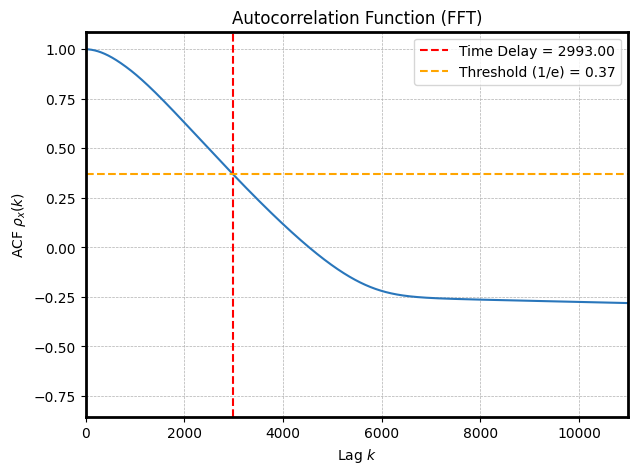

Selected  delay: 2993.0


In [11]:
# Plot the autocorrelation and mark the selected time delay
bluish = '#2976bb'
fig, ax = plt.subplots(figsize=(7, 5), dpi=100)
ax.set_title('Autocorrelation Function (FFT)')
ax.plot(time_delays, autocorrelation_values, color=bluish)
ax.set_xlabel(r'Lag $k$')
ax.set_ylabel(r'ACF $\rho_x(k)$')
plt.grid(True, which='both', ls='--', lw=0.5)

# Mark the time delay
ax.axvline(x=time_delay_value, color='r', linestyle='--', label=f'Time Delay = {time_delay_value:.2f}')
# Mark the threshold
ax.axhline(y=threshold, color='orange', linestyle='--', label=f'Threshold (1/e) = {threshold:.2f}')
set_spines_black(ax)
ax.legend()
ax.set_xlim(0, time_delay_idx + 8000) 
plt.savefig("Plots_4/TimeDelay_Oregonator_model.pdf", bbox_inches="tight")
plt.show()
print(f"Selected  delay: {time_delay_value}")



In [12]:
## Embedding Dimesion

['false_nearest', '/tmp/pytisean_temp_2025-07-07-14-42-10_ge98mrap.dat', '-m', '1', '-M', '1,10', '-d', '2993', '-f', '2', '-V', '0', '-o', '/tmp/pytisean_temp_2025-07-07-14-42-10_ui_53e20.dat']



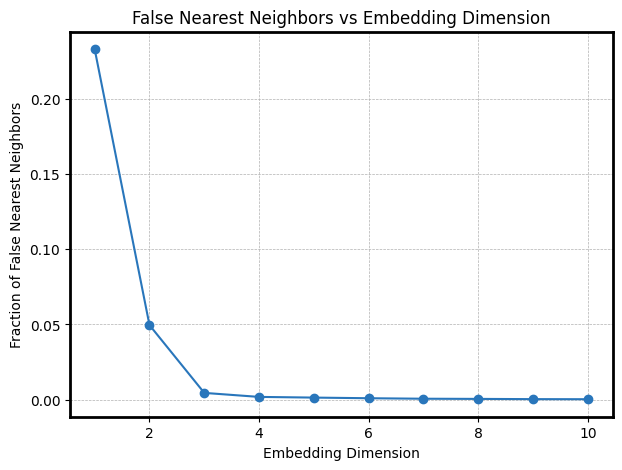

In [13]:
fnn_information, msg = tiseanio('false_nearest', '-m', 1, '-M', '1,10', '-d', 2993, '-f', 2, '-V', 0, data=x_t)
# Plot the fraction of false nearest neighbors against embedding dimension
embedding_dimensions = fnn_information[:, 0]  # First column: embedding dimensions
fnn_values = fnn_information[:, 1]            # Second column: fraction of false nearest neighbors

bluish = '#2976bb'
fig, ax = plt.subplots(figsize=(7, 5), dpi=100)
ax.set_title('False Nearest Neighbors vs Embedding Dimension')
ax.plot(embedding_dimensions, fnn_values, color=bluish, marker='o')
ax.set_xlabel('Embedding Dimension')
ax.set_ylabel('Fraction of False Nearest Neighbors')
set_spines_black(ax)
plt.grid(True, which='both', ls='--', lw=0.5)
plt.savefig("Plots_4/Embedding_Dimension_Oregonator_model.pdf", bbox_inches="tight")
plt.show()

In [14]:
fnn_values

array([0.2331954 , 0.04956472, 0.00445269, 0.00178393, 0.00132724,
       0.0008991 , 0.00057086, 0.00045669, 0.0002997 , 0.00024261])

In [15]:
## Time Delay = 2993
## Embedding Dimension = 3

In [16]:
# To generate delay vectors
delay_information, msg = tiseanio('delay', '-m', 3, '-d', 2993, '-V', 0, data=x_t)

['delay', '/tmp/pytisean_temp_2025-07-07-14-45-14_re24zttq.dat', '-m', '3', '-d', '2993', '-V', '0', '-o', '/tmp/pytisean_temp_2025-07-07-14-45-14_efqy4tv3.dat']



In [17]:
delay_information

array([[0.00016241, 0.00016113, 0.1       ],
       [0.00016241, 0.00016113, 0.09996305],
       [0.00016242, 0.00016114, 0.09988876],
       ...,
       [0.00021344, 0.00018112, 0.0001693 ],
       [0.00021347, 0.00018113, 0.0001693 ],
       [0.0002135 , 0.00018113, 0.0001693 ]])

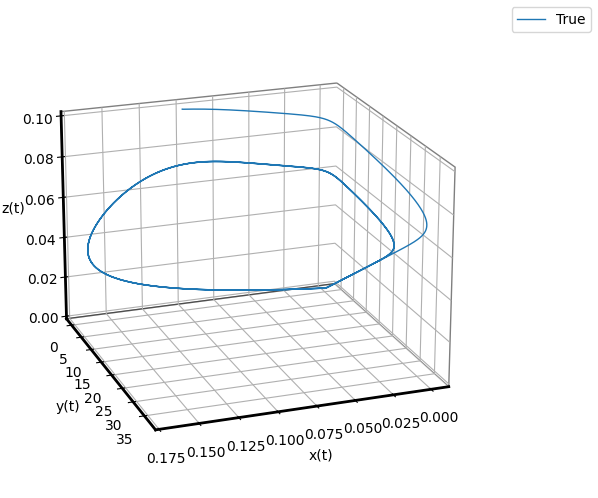

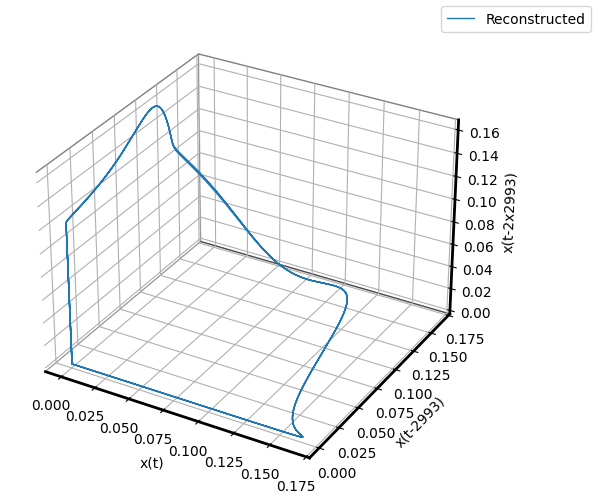

In [18]:
# Phase Digram
# 1) True Phase Digram
fig1 = plt.figure(figsize=(7, 5), dpi=100)
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot(
    x_train[:, 0], x_train[:, 1], x_train[:, 2],
    lw=1.0, label='True'
)
ax1.set(xlabel='x(t)', ylabel='y(t)', zlabel='z(t)')
ax1.grid(True, which='both', ls='--', lw=0.5)
fig1.legend()
set_spines_black_3d(ax1)
ax1.view_init(elev=20, azim=70)
fig1.tight_layout()
plt.savefig("Plots_2/True_phase_Oregonator_model.pdf", bbox_inches="tight")
plt.show()

# 2) Reconstructed Phase Digram: [x(t), x(t-tau), x(t- 2.tau)]
fig2 = plt.figure(figsize=(7, 5), dpi=100)
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot(
     delay_information[:, 0],
     delay_information[:, 1],
     delay_information[:, 2],
     lw=1.0, label='Reconstructed')
ax2.set(xlabel='x(t)', ylabel='x(t-2993)', zlabel='x(t-2x2993)')
fig2.legend()
ax2.grid(True, which='both', ls='--', lw=0.5)
# ax2.view_init(elev=50, azim=60)
set_spines_black_3d(ax2)
fig2.tight_layout()
plt.savefig("Plots_2/Reconstructed_phase_Oregonator_model.pdf", bbox_inches="tight")
plt.show()



In [19]:
# Extracting the Latent Features

In [20]:
# Perform SVD 
U, S, Vt = np.linalg.svd(delay_information,  full_matrices = False)

In [21]:
print(U)

[[-2.34485538e-03  4.26953956e-03 -5.07348582e-03]
 [-2.34399226e-03  4.26795934e-03 -5.07160985e-03]
 [-2.34225688e-03  4.26478225e-03 -5.06783810e-03]
 ...
 [-1.46400815e-05 -1.97852247e-06 -6.16021005e-06]
 [-1.46409550e-05 -1.97957281e-06 -6.16127957e-06]
 [-1.46418308e-05 -1.98062742e-06 -6.16235426e-06]]


In [22]:
print("Shape of embedded data:", delay_information.shape)
print("Shape of U:", U.shape)
print("Shape of S:", S.shape)
print("Shape of Vt:", Vt.shape)

Shape of embedded data: (94014, 3)
Shape of U: (94014, 3)
Shape of S: (3,)
Shape of Vt: (3, 3)


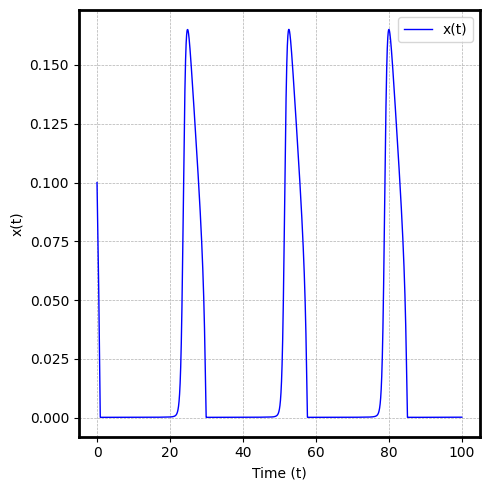

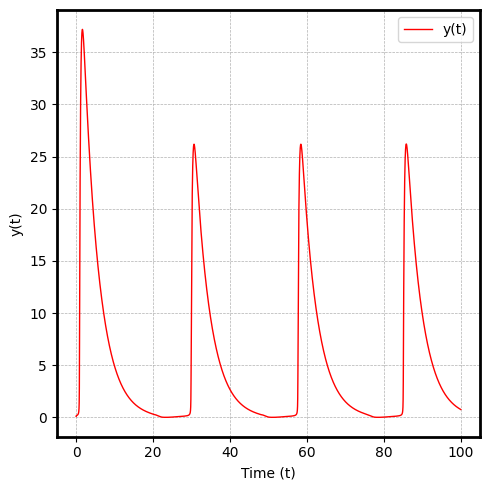

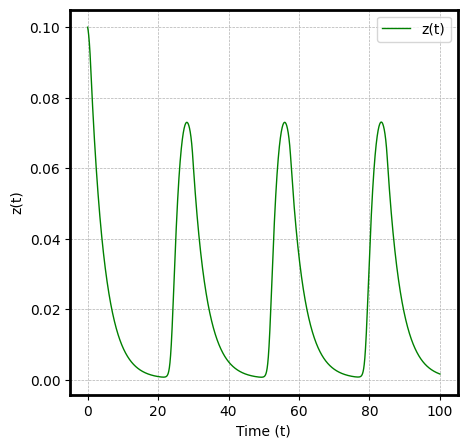

In [23]:
# Plot the original time series obtained corresponding to each variable
# First variable x(t)
fig1, ax1 = plt.subplots(figsize=(5, 5), dpi=100)
ax1.plot(t_train, x_train[:, 0], color='b', lw=1.0, label='x(t)')
ax1.set(xlabel='Time (t)', ylabel='x(t)')
ax1.legend(loc='best')
ax1.grid(True, which='both', ls='--', lw=0.5)
set_spines_black(ax1)
fig1.tight_layout()
plt.show()


# Second variable y(t)
fig2, ax2 = plt.subplots(figsize=(5, 5), dpi=100)
ax2.plot(t_train, x_train[:, 1], color='r', lw=1.0, label='y(t)')
ax2.set(xlabel='Time (t)', ylabel='y(t)')
ax2.legend(loc='best')
ax2.grid(True, which='both', ls='--', lw=0.5)
set_spines_black(ax2)
fig2.tight_layout()
plt.show()

# Second variable z(t)
fig3, ax3 = plt.subplots(figsize=(5, 5), dpi=100)
ax3.plot(t_train, x_train[:, 2], color='g', lw=1.0, label='z(t)')
ax3.set(xlabel='Time (t)', ylabel='z(t)')
ax3.legend(loc='best')
ax3.grid(True, which='both', ls='--', lw=0.5)
set_spines_black(ax3)
fig2.tight_layout()
plt.show()


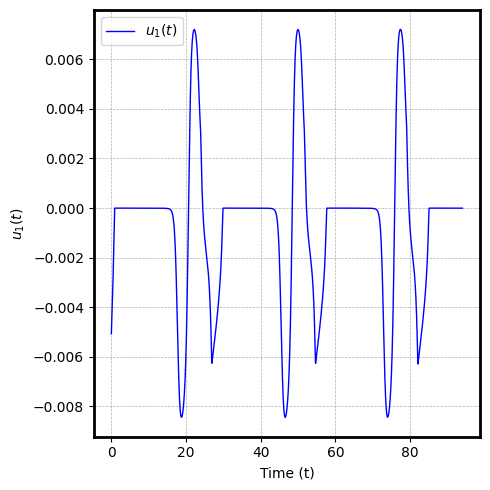

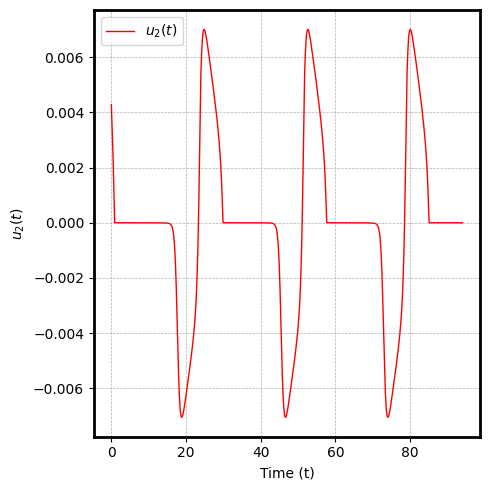

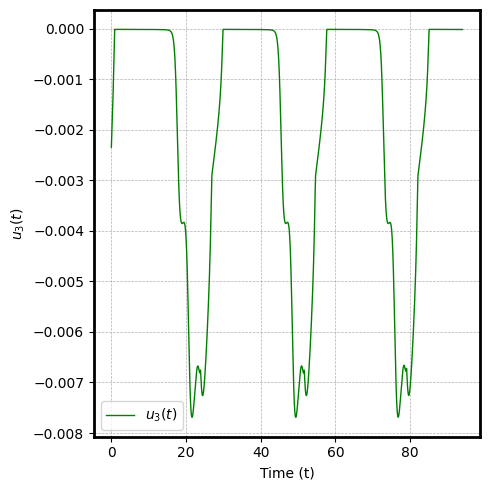

In [24]:
# Plot the time series obtained using SVD
min_len = min(len(t_train), len(U[:, 0]))
fig1, ax1 = plt.subplots(figsize=(5, 5), dpi=100)
ax1.plot(t_train[:min_len], U[:, 2], color='b', lw=1.0, label='$u_1(t)$')
ax1.set(xlabel='Time (t)', ylabel='$u_1(t)$')
ax1.legend(loc='best')
ax1.grid(True, which='both', ls='--', lw=0.5)
set_spines_black(ax1)
fig1.tight_layout()
plt.savefig("Plots_4/Latent_u1_Oregonator_Nagumo_model.pdf", bbox_inches="tight")
plt.show()


fig2, ax2 = plt.subplots(figsize=(5, 5), dpi=100)
ax2.plot(t_train[:min_len], U[:, 1], color='r', lw=1.0, label='$u_2(t)$')
ax2.set(xlabel='Time (t)', ylabel='$u_2(t)$')
ax2.legend(loc='best')
ax2.grid(True, which='both', ls='--', lw=0.5)
set_spines_black(ax2)
fig2.tight_layout()
plt.savefig("Plots_4/Latent_u2_Oregonator_Nagumo_model.pdf", bbox_inches="tight")
plt.show()
 
fig3, ax3 = plt.subplots(figsize=(5, 5), dpi=100)
ax3.plot(t_train[:min_len], U[:, 0], color='g', lw=1.0, label='$u_3(t)$')
ax3.set(xlabel='Time (t)', ylabel='$u_3(t)$')
ax3.legend(loc='best')
ax3.grid(True, which='both', ls='--', lw=0.5)
set_spines_black(ax3)
fig3.tight_layout()
plt.savefig("Plots_4/Latent_u3_Oregonator_Nagumo_model.pdf", bbox_inches="tight")
plt.show()


In [25]:
#------------------------------------------------------------------------------------------------------------------------------------------------#
#                                                                         END
#------------------------------------------------------------------------------------------------------------------------------------------------#